<a id='top'></a>
## Walmart and Weather
https://www.kaggle.com/competitions/walmart-recruiting-sales-in-stormy-weather/data
* Note : Cells should run by order <br><br>

[* Temperature](#temp) <br>
[* Rainy Days](#rainy) <br>
[* Humidity](#humidity) <br>
[* Sales](#sales) <br>
[* Item Sales](#itemsales) <br>
[* Store Sales](#storesales) <br>

[* Transform: Dropping Columns and Rows](#transform) <br>
[* Imputation](#imp) <br>
[* Transform: New Columns](#newcol) <br>
[* Transform : Creating new table, Merging, Adding new columns](#transC) <br>
[* Transform : Merging Sales with Weather, Adding new columns](#transD) <br>
[* Feature Selection: Feature Importance for Rainy Days](#feat) <br>
[* Feature Selection: Correlation Matrix](#cor) <br>

[Unit Sales Prediction](#C) <br>
    [* Model A](#model1) <br>
    [* Model B](#model2) <br>

[Rainy Day Prediction](#D) <br>
    [* Model A](#model3) <br>
    [* Model B](#model4) <br>

#### Importing Libraries, Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import math
import random


#Reading Data
key_df = pd.read_csv('key.csv')
weather_df = pd.read_csv('weather.csv')
sales_df = pd.read_csv('sales.csv')

<a id='A'></a>
#### Data Exploration and Visualization

 - Exploring 'key.csv'

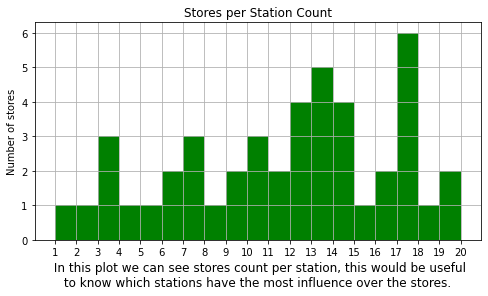

,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


In [2]:

list_stations = [ * range (1,21)]
key_df.hist(figsize=(8,4),column = ['station_nbr'], bins = list_stations , color = 'green' )
plt.xticks(ticks=list_stations)
plt.title("Stores per Station Count")
plt.ylabel("Number of stores")
plt.xlabel(''' In this plot we can see stores count per station, this would be useful
 to know which stations have the most influence over the stores. ''', fontsize = 12)
plt.show()
key_df.head(5)

### Exploring 'weather.csv'

In [3]:
display(weather_df.sample(n=5))
temp_df = weather_df.copy()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
2649,10,2012-05-19,83,70,77,M,61,66,0,12,0531,1915,,M,0.00,29.96,30.00,9.9,02,11.0
712,11,2012-02-07,70,49,60,6,51,55,5,0,0714,1808,BR,0.0,0.00,30.07,30.11,5.6,04,6.3
15757,1,2014-03-08,51,22,37,M,21,31,28,0,-,-,,M,0.00,29.66,29.81,4.1,33,4.7
19762,6,2014-09-24,84,55,70,-6,57,62,0,5,0620,1826,,0.0,0.00,29.57,30.09,2.6,05,2.9
5941,14,2012-10-31,72,44,58,2,39,48,7,0,0651,1737,,0.0,0.00,28.64,30.01,4.0,35,5.6


<a id='temp'></a>
[Back to Top](#top)<br>
### Temperature
##### Exploring average temperature throughout the days 


###### displaying average temperature each month of the year (from all years)

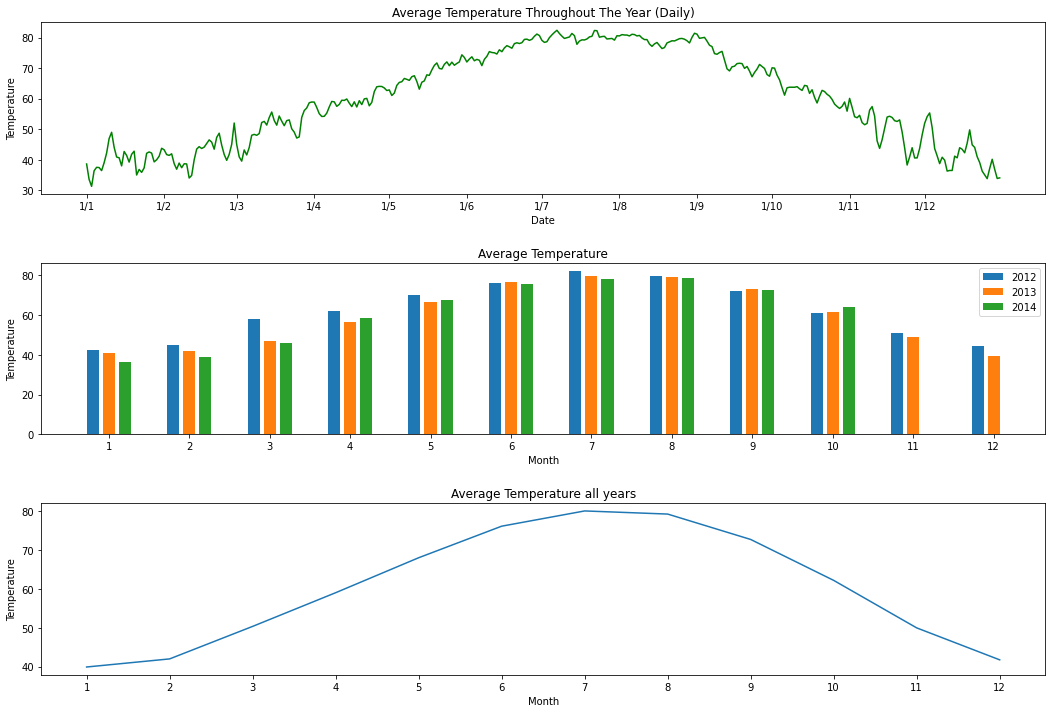

In [4]:
temp_df2 = weather_df.copy()
temp_df2 = temp_df2[temp_df2['tavg'] != 'M']
temp_df2['tavg'] =  pd.to_numeric(temp_df2['tavg'])
temp_df2['date'] =  pd.to_datetime(temp_df2['date'], format='%Y-%m-%d')
temp_df2['day'] = pd.DatetimeIndex(temp_df2['date']).day
temp_df2['month'] = pd.DatetimeIndex(temp_df2['date']).month
temp_df2['year'] = pd.DatetimeIndex(temp_df2['date']).year

plt.figure(figsize=(18,12))
plt.subplot(3,1, 1)
plt.subplots_adjust(hspace = 0.4)
grouped_df = temp_df2.groupby(["month", "day"]).agg({'tavg': ['mean']}).reset_index()
sum_df = grouped_df
sum_df['date'] = pd.to_datetime(dict(year= 2020, month=sum_df['month'], day=sum_df['day']))
plt.plot(sum_df['date'], sum_df['tavg'], color = 'green')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Average Temperature Throughout The Year (Daily)")
plt.xticks(ticks = ['2020-0'+ str(i) + '-01' for i in range(1,10)] + ['2020-'+ str(i) + '-01' for i in range(10,13)]
               , labels = ['1/' + str(i) for i in range(1,13) ] )


pos = -0.2
width = 0.15
plt.subplot(3,1, 2)
for i in [2012,2013,2014]:
    temp_df3 = temp_df2[temp_df2['year'] == i]
    grouped_df = temp_df3.groupby("month")
    mean_df = grouped_df['tavg'].mean().reset_index()
    plt.xticks(ticks = [i for i in range (1,13)] , labels = [str(i) for i in range (1,13)] )
    plt.bar(mean_df['month']+pos, mean_df['tavg'],width, label = str(i))
    pos+= 0.2

plt.legend()
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.title("Average Temperature")
#plt.show()

plt.subplot(3,1, 3)
#plt.figure(figsize=(12,4))
grouped_df = temp_df2.groupby("month")
mean_df = grouped_df['tavg'].mean()
plt.plot(mean_df)
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.title("Average Temperature all years")
plt.xticks(ticks = [i for i in range (1,13)] , labels = [str(i) for i in range (1,13)] )
plt.show()




<a id='rainy'></a>
#### Rainy Days
 notice that 'Station 5' have plenty of missing data - which affects one store 
(rainy day is defined perciptotal > 0.0)

[Back to Top](#top)<br>

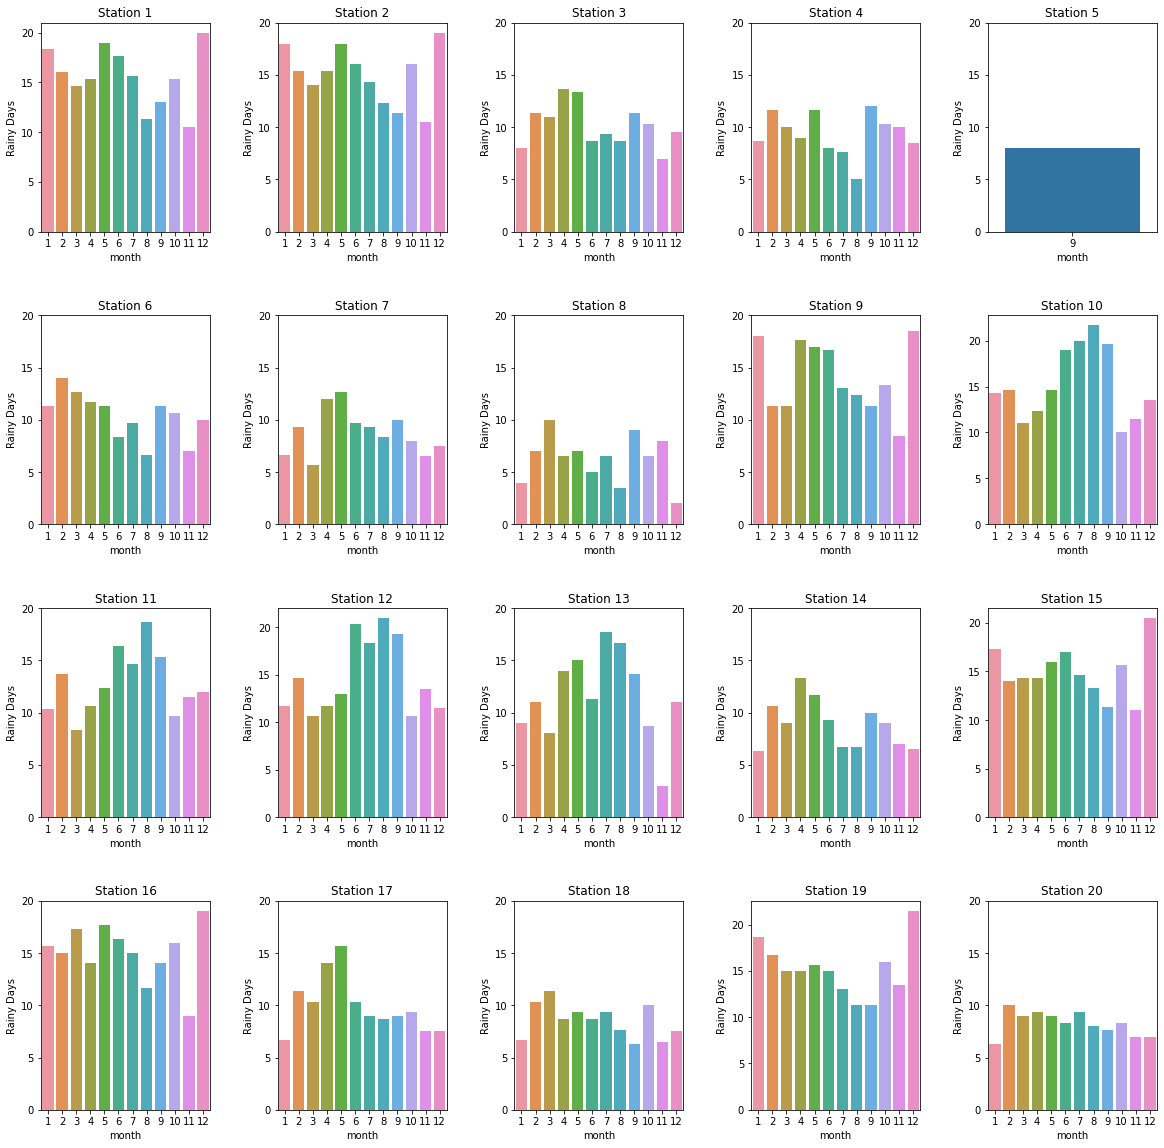

In [5]:
temp_df2 = temp_df2.copy()

temp_df2.loc[temp_df2['preciptotal'].str.contains('T') , 'preciptotal'] = 9
temp_df2 = temp_df2[temp_df2['preciptotal'] != 'M']

temp_df2['preciptotal'] = pd.to_numeric(temp_df2['preciptotal'])
temp_df2 = temp_df2[temp_df2['preciptotal'] > 0]

grouped_df = temp_df2.groupby(["year","month","station_nbr"])
sum_df = grouped_df['preciptotal'].count().reset_index()

grouped_df = sum_df.groupby(["month" , "station_nbr"])
sum_df = grouped_df['preciptotal'].mean().reset_index()


# Plotting for each station
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace = 0.4)
plt.subplots_adjust(hspace = 0.4)
for i in range(1,21):
    plt.subplot(4,5, i)
    temp_df3 = sum_df[sum_df['station_nbr']==i]
    sns.barplot(y = 'preciptotal', x = 'month',data = temp_df3)
    plt.title ("Station " + str(i))
    plt.ylabel("Rainy Days")
    plt.yticks(ticks = [20,15,10,5,0] , labels = ['20','15','10','5','0'])
    

plt.show()




<a id='humidity'></a>
#### Humidity (dewpoint , wetbulb)  
* notice that 'Station 5' have plenty of missing data - which affects one store 

[Back to Top](#top)<br>

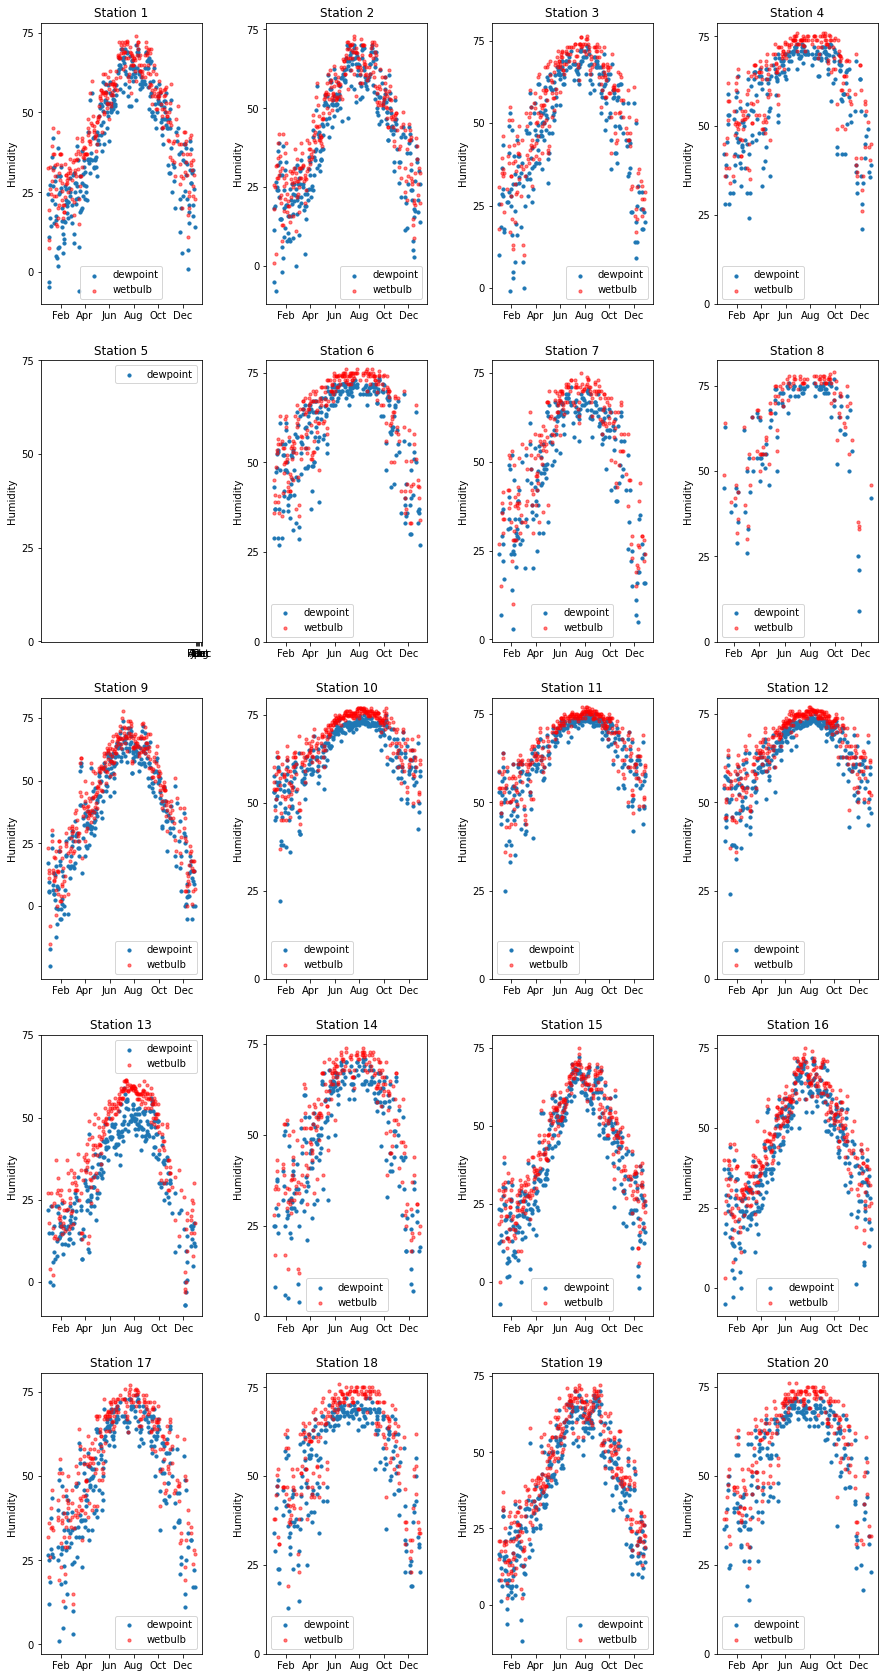

In [6]:
import datetime
temp_df2 = temp_df2.copy()
temp_df2['day'] = pd.DatetimeIndex(temp_df2['date']).day

temp_df2 = temp_df2[temp_df2['dewpoint'] != 'M']
temp_df2 = temp_df2[temp_df2['wetbulb'] != 'M']
temp_df2['dewpoint'] = pd.to_numeric(temp_df2['dewpoint'])
temp_df2['wetbulb'] = pd.to_numeric(temp_df2['wetbulb'])


# Plotting for each station
plt.figure(figsize=(15,30))
plt.subplots_adjust(wspace = 0.4)


grouped_df = temp_df2.groupby(["month", "day" , "station_nbr"]).agg({'dewpoint': ['mean'], 'wetbulb': ['mean']}).reset_index()
#sum_df = grouped_df['dewpoint' , 'wetbulb' ].mean().reset_index()
#sum_df['date'] = pd.to_datetime(dict(year= 2020, month=sum_df['month'], day=sum_df['day']))
sum_df = grouped_df
sum_df['date'] = pd.to_datetime(dict(year= 2020, month=sum_df['month'], day=sum_df['day']))

for i in range(1,21):
    plt.subplot(5,4, i)
    temp_df3 = sum_df[sum_df['station_nbr']==i]
    plt.scatter(temp_df3['date'],temp_df3['dewpoint'] , s = 10 , label = 'dewpoint')
    if i != 5:
        plt.scatter(temp_df3['date'],temp_df3['wetbulb'] , color = 'red',alpha=0.5 , s=10 , label = 'wetbulb')
    plt.xticks(ticks = ['2020-02-01','2020-04-01','2020-06-01', '2020-08-01','2020-10-01','2020-12-01'] 
               , labels = ['Feb','Apr','Jun','Aug','Oct','Dec'])
    plt.yticks(ticks = [75,50,25,0] , labels = ['75','50','25','0'])
    plt.title ("Station " + str(i))
    plt.ylabel("Humidity")
    plt.legend()

plt.show()




<a id='sales'></a>
## Exploring 'sales.csv' 
* Stores 33 , 17 , 16 have huge sales lead over other stores
* During winter season -  sales go up

[Back to Top](#top)<br>

In [7]:
sales_df.sample(5)

,date,store_nbr,item_nbr,units
3563713,2014-02-15,10,59,0
2312611,2013-04-16,24,38,0
2011418,2013-02-11,3,99,0
3606272,2014-02-25,14,105,0
1820233,2013-01-03,36,56,0


In [8]:
from IPython.core.display import display, HTML

temp_df3 = sales_df.copy()
temp_df3['date'] =  pd.to_datetime(temp_df3['date'], format='%Y-%m-%d')
temp_df3['month'] = pd.DatetimeIndex(temp_df3['date']).month
temp_df3['year'] = pd.DatetimeIndex(temp_df3['date']).year

temp_df3 = temp_df3.merge(key_df, on='store_nbr')


#helper function to display tables
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))   



#most sold items
grouped_df = temp_df3.groupby(["item_nbr"])
sum_df = grouped_df['units'].sum().reset_index()
df_list = [sum_df.nlargest(10, 'units')]
df_label = ["Top10 Most Sold Items:"]

#most selling stores
grouped_df = temp_df3.groupby(["store_nbr"])
sum_df = grouped_df['units'].sum().reset_index()
df_list.append(sum_df.nlargest(10, 'units'))
df_label.append("Top10 Most Selling Stores:")

#most selling months
grouped_df = temp_df3.groupby(["month"])
sum_df = grouped_df['units'].sum().reset_index()
df_list.append(sum_df.nlargest(12, 'units'))
df_label.append("Most Selling Months:")

#most selling stores per month
grouped_df = temp_df3.groupby(["month" , "store_nbr"])
sum_df = grouped_df['units'].sum().reset_index()
df_list.append(sum_df.loc[sum_df.groupby("month")["units"].idxmax()])
df_label.append("Most Selling Stores per Month:")

#most sold items per store
grouped_df = temp_df3.groupby(["store_nbr" , "item_nbr"])
sum_df = grouped_df['units'].sum().reset_index()
x = sum_df.loc[sum_df.groupby("item_nbr")["units"].idxmax()]
df_list.append(x.nlargest(10, 'units'))
df_label.append("Top10 Most Sold Items per Store:")


display_side_by_side(df_list, df_label)


,item_nbr,units
44,45,1005111
8,9,916615
4,5,846662
43,44,577193
15,16,226772
67,68,172243
24,25,148253
36,37,125156
35,36,83865
47,48,76092


<a id='itemsales'></a>
### Displaying most sold items over months (on average):

[Back to Top](#top)<br>

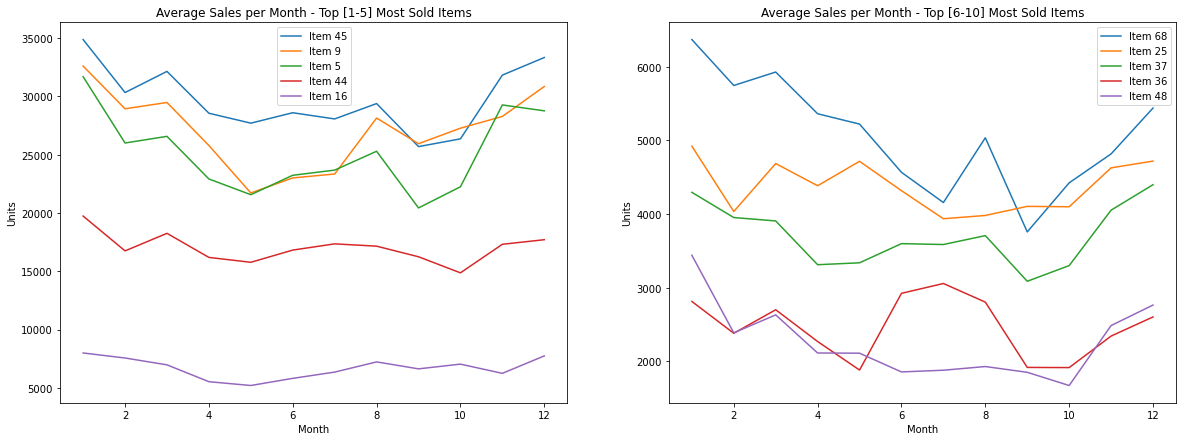

In [9]:

plt.figure(figsize=(20,7))

plt.subplot(1,2, 1)
for i in [45,9,5,44,16]:    
    temp_df2 = temp_df3.copy()
    temp_df2 = temp_df2[temp_df2['item_nbr'] == i]
    grouped_df = temp_df2.groupby("month")
    mean_df = grouped_df['units'].sum().reset_index()

    mean_df.loc[mean_df['month'] < 11, 'units'] /= 3
    mean_df.loc[mean_df['month'] > 10, 'units'] /= 2
    plt.plot(mean_df['month'], mean_df['units'], label = 'Item ' +str(i))
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Average Sales per Month - Top [1-5] Most Sold Items")
    
plt.subplot(1,2, 2)
for i in [68,25,37,36,48]:    
    temp_df2 = temp_df3.copy()
    temp_df2 = temp_df2[temp_df2['item_nbr'] == i]
    grouped_df = temp_df2.groupby("month")
    mean_df = grouped_df['units'].sum().reset_index()

    mean_df.loc[mean_df['month'] < 11, 'units'] /= 3
    mean_df.loc[mean_df['month'] > 10, 'units'] /= 2
    plt.plot(mean_df['month'], mean_df['units'], label = 'Item ' +str(i))
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Average Sales per Month - Top [6-10] Most Sold Items")

plt.show()


<a id='storesales'></a>
### Displaying most selling stores over months (on average):

[Back to Top](#top)<br>


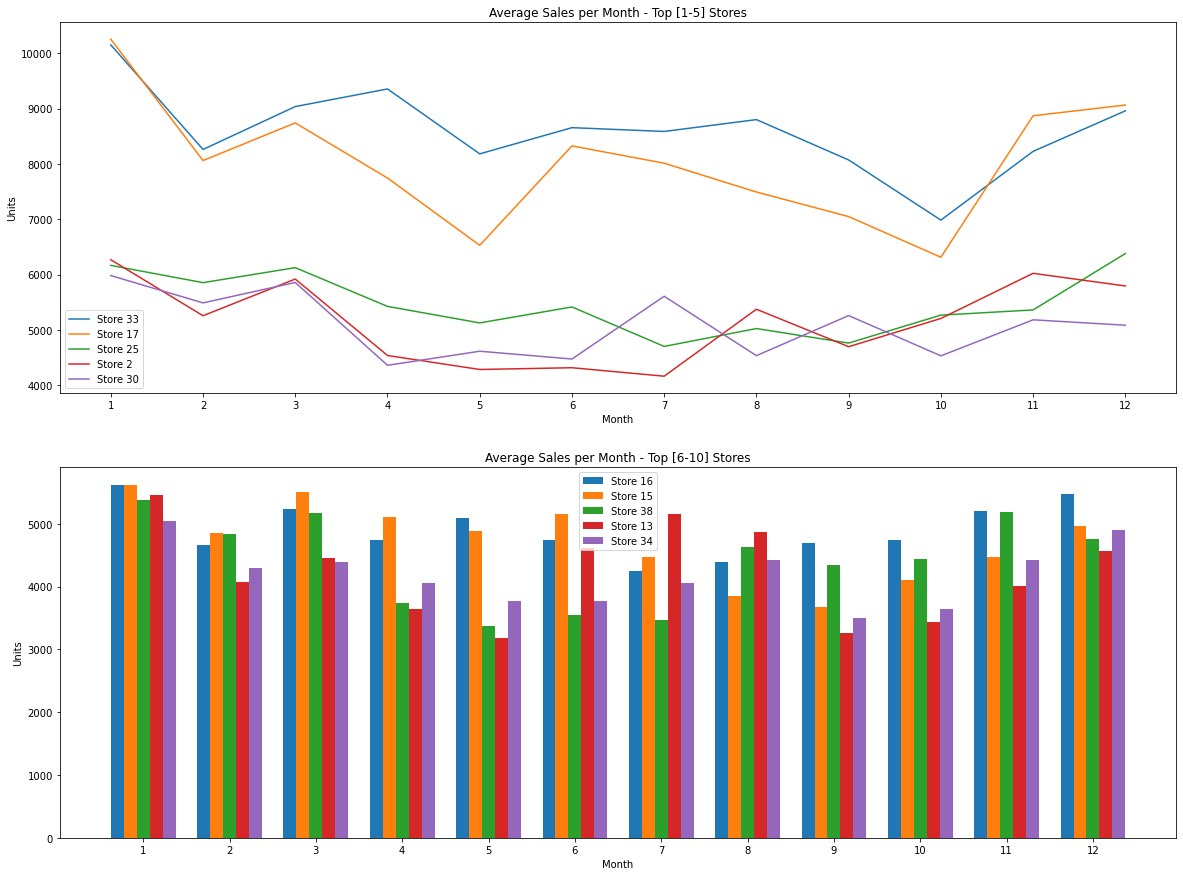

In [10]:
plt.figure(figsize=(20,15))


plt.subplot(2,1, 1)
for i in [33,17,25,2,30]:    
    temp_df2 = temp_df3.copy()
    temp_df2 = temp_df2[temp_df2['store_nbr'] == i]
    grouped_df = temp_df2.groupby(["month",'store_nbr'])
    mean_df = grouped_df['units'].sum().reset_index()

    mean_df.loc[mean_df['month'] < 11, 'units'] /= 3
    mean_df.loc[mean_df['month'] > 10, 'units'] /= 2
    plt.plot(mean_df['month'], mean_df['units'], label = 'Store ' +str(i))
    plt.legend()
    plt.xticks ( [i for i in range (1,13)], [str(i) for i in range (1,13)])
    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Average Sales per Month - Top [1-5] Stores")

width = 0.15
pos = -0.3
plt.subplot(2,1, 2)
for i in [16,15,38,13,34]:    
    temp_df2 = temp_df3.copy()
    temp_df2 = temp_df2[temp_df2['store_nbr'] == i]
    grouped_df = temp_df2.groupby(["month",'store_nbr'])
    mean_df = grouped_df['units'].sum().reset_index()

    mean_df.loc[mean_df['month'] < 11, 'units'] /= 3
    mean_df.loc[mean_df['month'] > 10, 'units'] /= 2
    plt.bar(mean_df['month']+pos, mean_df['units'],width, label = 'Store ' +str(i))
    pos += 0.15
    plt.legend()
    plt.xticks ( [i for i in range (1,13)], [str(i) for i in range (1,13)])
    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.title("Average Sales per Month - Top [6-10] Stores")

<a id='transform'></a>
### Transform :
#### Dropping Columns that are not relevant

#### Dropping Rows for Station 5 :

###### and therefore we will have to drop 'Store 35' Sales for following sections, since these will not contribute to us without weather

#### Dropping Rows Where 'perciptotal' is Missing :
 - for missing data ('M') in column 'perciptotal' will drop the rows (only 38 in total) - perciptotal is basically the indicator for target when it comes to rainy days therefore we rather just drop the data

[Back to Top](#top)<br>

In [11]:
weather_df2 = pd.read_csv('weather.csv')

weather_df2.drop(['sealevel','sunrise','sunset','depart','heat','cool'], axis=1, inplace=True)




print("Missing data ('M') in column 'perciptotal': " , len(weather_df2[weather_df2['preciptotal'] == 'M']))

weather_df2.drop(weather_df2[weather_df2['preciptotal'] == 'M'].index, inplace=True)


weather_df2.sample(5) 

Missing data ('M') in column 'perciptotal':  38


,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,codesum,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed
15166,10,2014-02-06,64,45,55,40,46,RA,M,0.31,30.14,11.7,36,13.1
2835,6,2012-05-29,93,72,83,70,74,,0.0,0.00,29.34,7.7,19,8.3
16,18,2012-01-01,59,40,50,28,40,,0.0,0.00,29.98,9.0,33,8.9
20114,18,2014-10-11,66,58,62,54,57,RA DZ BR,0.0,0.29,29.52,9.7,31,10.0
8339,12,2013-02-28,71,50,61,38,49,,0.0,0.00,29.88,8.3,28,9.0


In [12]:
weather_df2['date'] =  pd.to_datetime(weather_df2['date'], format='%Y-%m-%d')
weather_df2['month'] = pd.DatetimeIndex(weather_df2['date']).month
weather_df2['year'] = pd.DatetimeIndex(weather_df2['date']).year

 <a id='imp'></a>
 ### Imputation : Filling Missing Data
 ##### After exploring data found two values that need to be filled ( 'T' , 'M' )
 ##### For all stations:
 - for missing data ('M') in cell<column,row> :  calculate the mean of the column in the same month and the same station for the rest of the data and set that as instead of the missing value. that way we will have a close estimate to the missing value.
 - for data in preciptotal (rain) that is ('T') - trace is anything less than can be measured, anything less than (0.01 inch) of rain is reported as a trace of rain therefore we will fill (0.005) 
 - for data in snowfall that is ('T') - trace amounts are defined as less than (0.05 inches) therefore we will fill as (0.025)
 
 [Back to Top](#top)<br>

In [13]:
def get_column_mean(df , column , month , station):
    temp = df[df['month'] == month]
    temp = temp[temp['station_nbr'] == station]
    temp = temp[temp[column] != 'M']
    temp[column] =  pd.to_numeric(temp[column])
    x = temp[column].mean()
    return 0.0 if math.isnan(x) else x

for i in weather_df2.columns:
    if i == 'codesum' or i=='date' or i=='station_nbr' or i == 'month' or i =='year':
        continue
    if i == 'snowfall':
        weather_df2.loc[weather_df2[i].str.contains('T',na=False), i] = 0.025
    if i== 'preciptotal':
        weather_df2.loc[weather_df2[i].str.contains('T',na=False), i] = 0.005
    for row in weather_df2[weather_df2[i].str.contains('M',na=False)].itertuples():
        x = get_column_mean(weather_df2 , i , row.month , row.station_nbr)
        weather_df2.at[row[0],i] = x
    weather_df2[i] = pd.to_numeric(weather_df2[i])
    
    
weather_df2.drop(['month','year'], axis=1, inplace=True)


<a id='newcol'></a>
## Transform : Creating new columns instead of 'codesum'
to make it easier for the models to handle the dataset we create new column for each value that appears in the 'codesum' in the dataset and we drop the codesum column. in addition we will add a new column 'target' for the Feature Selection process.

 [Back to Top](#top)<br>

In [14]:
temp_weather_df = weather_df2.copy()

codesum_df = weather_df2[weather_df2['codesum'] != ' ']
weather_code = set()

for i in weather_df2['codesum'].to_list():
    if i == ' ':
        continue
    for j in i.split():
        if len(j)>3:
            x = [j[i:i+2] for i in range(0, len(j), 2)]
            for k in x:
                weather_code.add(k) 
            continue
        weather_code.add(j)
weather_code = list(weather_code)

for i in weather_code:
    temp_weather_df[i] = 0
    temp_weather_df.loc[temp_weather_df['codesum'].str.contains(i ,na=False), i] = 1

temp_weather_df.drop(['codesum'], axis=1, inplace=True)    

temp_weather_df.columns

Index(['station_nbr', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'snowfall', 'preciptotal', 'stnpressure', 'resultspeed', 'resultdir',
       'avgspeed', 'DU', 'HZ', 'BR', 'GR', 'FU', 'BL', 'FG+', 'BC', 'SN', 'GS',
       'PL', 'FG', 'PR', 'SG', 'VC', 'UP', 'MI', 'FZ', 'DZ', 'SQ', 'RA', 'TS'],
      dtype='object')

In [15]:
key_df[key_df['store_nbr'] == 11]

,store_nbr,station_nbr
10,11,10


<a id='transC'></a>
## Transform : Creating new table, Merging Sales,key_csv, Weather_csv, Adding new columns 
* Merging sales and key_csv and weather to get the weather information of days , per store.
* Adding key_sum columns as instructed


 [Back to Top](#top)<br>

In [16]:
sales_df_c = sales_df.copy()
sales_df_c2 = sales_df_c[sales_df_c['item_nbr'].isin([5,6,9,16,45])]



grouped_df =sales_df_c2.groupby(["date" , "store_nbr"])
mean_df = grouped_df['units'].sum().reset_index()

mean_df.rename({"units": "key_sum"}, axis="columns", inplace=True)

secC_temp = pd.merge(mean_df,key_df, on=["store_nbr"])
secC_temp['date'] =  pd.to_datetime(secC_temp['date'], format='%Y-%m-%d')

sectionC_df = pd.merge(secC_temp , temp_weather_df , on=["station_nbr" , "date"] )

sectionC_df.sample(5)

,date,store_nbr,key_sum,station_nbr,tmax,tmin,tavg,dewpoint,wetbulb,snowfall,...,PR,SG,VC,UP,MI,FZ,DZ,SQ,RA,TS
6068,2013-09-18,28,37,7,92.0,72.0,82.0,63.0,69.0,0.0,...,0,0,0,0,0,0,0,0,0,0
37374,2014-03-27,21,55,3,81.0,50.0,66.0,44.0,53.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35967,2012-10-04,21,17,3,79.0,56.0,68.0,53.0,59.0,0.0,...,0,0,0,0,0,0,0,0,1,0
21310,2012-04-13,11,32,10,78.0,64.0,71.0,56.0,62.0,0.0,...,0,0,0,0,0,0,0,0,0,0
18285,2013-05-09,23,51,17,74.0,59.0,67.0,61.0,63.0,0.0,...,0,0,0,0,0,0,0,0,1,1


<a id='transD'></a>
## Transform : Merging Sales with Weather, Adding new columns 
* Merging sales and weather to get the target column (rainy = 1 , not rainy = 0) in order to run the models
* Adding columns for each item that has sales, and the numbers of sales for that item , this will provide more information for the models we're going to use


 [Back to Top](#top)<br>

In [17]:
# Adding Target Column
weather_df3 = temp_weather_df.copy()
weather_df3.loc[weather_df3['preciptotal'] > 0, 'target'] = 1
weather_df3.loc[weather_df3['preciptotal'] == 0, 'target'] = 0 
weather_df3['target'] = pd.to_numeric(weather_df3['target'])
weather_df3.sample(5)

,station_nbr,date,tmax,tmin,tavg,dewpoint,wetbulb,snowfall,preciptotal,stnpressure,...,SG,VC,UP,MI,FZ,DZ,SQ,RA,TS,target
9554,7,2013-04-30,83.0,63.0,73.0,55.0,62.0,0.0,0.000,28.37,...,0,0,0,0,0,0,0,0,0,0.0
7934,7,2013-02-08,53.0,29.0,41.0,28.0,36.0,0.0,0.000,28.82,...,0,0,0,0,0,0,0,0,0,0.0
4531,4,2012-08-22,92.0,71.0,82.0,64.0,70.0,0.0,0.005,29.33,...,0,0,0,0,0,0,0,1,0,1.0
18014,18,2014-06-28,90.0,77.0,84.0,72.0,75.0,0.0,0.005,29.36,...,0,0,0,0,0,0,0,1,0,1.0
6299,12,2012-11-18,67.0,56.0,62.0,50.0,54.0,0.0,0.000,30.17,...,0,0,0,0,0,0,0,0,0,0.0


In [18]:
tt = sales_df[sales_df['units'] > 0]
tt = tt[tt['store_nbr'] == 11]
tt['item_nbr'].value_counts()

9      898
68     897
87     428
61     254
110    138
86      90
Name: item_nbr, dtype: int64

In [19]:
sales_df_d = sales_df.copy()
weather_df_d = weather_df3.copy()

sales_df_d = sales_df_d[sales_df_d['store_nbr'] == 11]
sales_df_d['date'] =  pd.to_datetime(sales_df_d['date'], format='%Y-%m-%d')

weather_df_d = weather_df_d[weather_df_d['station_nbr'] == 10]
#sales_df2[pd.DatetimeIndex(sales_df2['date']).year < 2014]

d_df =  pd.merge(sales_df_d, weather_df_d[["date",'target']], on=["date"])

d_df = d_df.sort_values(['date','units'], ascending=False)


grouped_df = d_df[d_df['units'] > 0].groupby(["item_nbr"])
mean_df = grouped_df['units'].sum().reset_index()


for i in mean_df['item_nbr'].to_list():
    d_df['item' + str(i)] = np.where(d_df['item_nbr'] == i , d_df['units'] , 0)

d_df.sample(5)


,date,store_nbr,item_nbr,units,target,item9,item61,item68,item86,item87,item110
14489,2012-05-10,11,60,0,0.0,0,0,0,0,0,0
35746,2012-11-18,11,5,0,0.0,0,0,0,0,0,0
86887,2014-06-16,11,86,0,1.0,0,0,0,0,0,0
34803,2012-11-09,11,61,0,0.0,0,0,0,0,0,0
35867,2012-11-19,11,15,0,0.0,0,0,0,0,0,0


In [20]:

sectionD_df = d_df[d_df['units'] > 0].groupby(["date"]).agg({'units':['sum'],'target': ['first'], 'item9': ['sum'], 'item61': ['sum'],
                    'item68': ['sum'], 'item86': ['sum'], 'item87': ['sum'], 'item110': ['sum']}).reset_index()
sectionD_df.columns = sectionD_df.columns.droplevel(1)
sectionD_df['date'] =  pd.to_datetime(sectionD_df['date'], format='%Y-%m-%d')
sectionD_df['month'] = pd.DatetimeIndex(sectionD_df['date']).month
sectionD_df['day'] = pd.DatetimeIndex(sectionD_df['date']).day
sectionD_df['Summer'] = 0
sectionD_df['Winter'] = 0 
sectionD_df['Spring']  = 0 
sectionD_df['Fall']  = 0

sectionD_df.loc[(sectionD_df['month'].isin([12,1,2])) , 'Winter'] = 1
sectionD_df.loc[(sectionD_df['month'].isin([3,4,5])) , 'Spring'] = 1
sectionD_df.loc[(sectionD_df['month'].isin([6,7,8])) , 'Summer'] = 1
sectionD_df.loc[(sectionD_df['month'].isin([9,10,11])) , 'Fall'] = 1

sectionD_df.sample(5)


,date,units,target,item9,item61,item68,item86,item87,item110,month,day,Summer,Winter,Spring,Fall
614,2013-11-14,83,0.0,39,0,44,0,0,0,11,14,0,0,0,1
576,2013-09-30,71,0.0,47,0,24,0,0,0,9,30,0,0,0,1
605,2013-10-29,36,0.0,9,0,27,0,0,0,10,29,0,0,0,1
106,2012-04-16,103,0.0,35,0,68,0,0,0,4,16,0,0,1,0
157,2012-06-06,62,1.0,32,0,29,1,0,0,6,6,1,0,0,0


<a id='feat'></a>
### Feature Selection
#### Feature importance
with the help of a built in model feature importance, we display the importance of the features when it comes to Rainy days. this can be helpful

[Back to Top](#top)<br>

[0.21539458 0.08214282 0.19781672 0.18998328 0.06723301 0.03836995
 0.10300215 0.05101709 0.03295048 0.00528581 0.00694734 0.00985675]


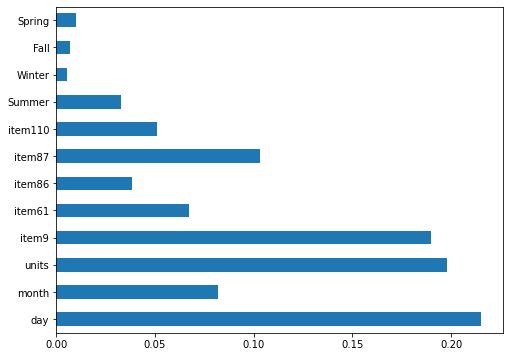

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
cols = sectionD_df[['day','month','units','item9' , 'item61' , 'item86' , 'item87' , 'item110' ,
                  'Summer','Winter','Fall','Spring']]
model.fit(cols,sectionD_df['target'])
print(model.feature_importances_) 
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=cols.columns)
plt.figure(figsize=(8,6))
feat_importances.plot(kind='barh')
plt.show()

### Importing 'sklearn' Libraries 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

<a id='C'></a>
 Unit Sales Prediction
[Back to Top](#top)<br>

##### Splitting data for Train, Test

In [26]:

secC_cols = list(sectionC_df.columns)
secC_cols.remove('date')
secC_cols.remove('station_nbr')
secC_cols.remove('key_sum')



df_train = sectionC_df[pd.DatetimeIndex(sectionC_df['date']).year < 2014]

x_train, y_train  = df_train[secC_cols] , df_train['key_sum']

df_test = sectionC_df[pd.DatetimeIndex(sectionC_df['date']).year == 2014]

x_test , y_test = df_test[secC_cols] , df_test['key_sum']



<a id='model1'></a>
##### Model A.
[Back to Top](#top)<br>

* Hyperparameter tuning

In [61]:
#grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
#               'weights' : ['uniform','distance'],
#               'metric' : ['minkowski','euclidean','manhattan']}

#gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
#g_res = gs.fit(x_train, y_train)
#g_res.best_params_
print("{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [27]:
module=KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance')
module.fit(x_train,y_train)
y_pre=(module.predict(x_test))
print('KNeighbors Regressor MSE: ',metrics.mean_squared_error(y_test,y_pre))
regression_results(y_test,y_pre)
#print("    Report \n",classification_report(y_pre,y_test))x

KNeighbors Regressor MSE:  2552.241866548475
explained_variance:  0.0717
mean_squared_log_error:  0.9592
r2:  -0.0162
MAE:  35.8143
MSE:  2552.2419
RMSE:  50.5197


<a id='model2'></a>
##### Model B.
[Back to Top](#top)<br>

* Hyperparameter tuning

In [68]:
#grid_params = {'max_depth': [2, 3, 5, 10, 20],
#    'min_samples_leaf': [5, 10, 20, 50, 100]
#}
#gs = GridSearchCV(DecisionTreeRegressor(), grid_params, verbose = 1, cv=3, n_jobs = -1)
#g_res = gs.fit(x_train, y_train)
#g_res.best_params_
print("{'max_depth': 2, 'min_samples_leaf': 100}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'max_depth': 2, 'min_samples_leaf': 100}

In [31]:
module2=DecisionTreeRegressor(max_depth= 2, min_samples_leaf= 100)
module2.fit(x_train,y_train)
y_pre2=(module2.predict(x_test))
print('DecisionTree Regressor MSE: ',metrics.mean_squared_error(y_test,y_pre2))
#print("    Report \n",classification_report(y_pre,y_test))
regression_results(y_test,y_pre2)

DecisionTree Regressor MSE:  2271.8774124105253
explained_variance:  0.2018
mean_squared_log_error:  1.1101
r2:  0.0954
MAE:  38.052
MSE:  2271.8774
RMSE:  47.6642


<a id='D'></a>
 Rainy Day Prediction
[Back to Top](#top)<br>

##### Splitting data for Train, Test

In [46]:
df_train = sectionD_df[pd.DatetimeIndex(sectionD_df['date']).year < 2014]

x_train, y_train  = df_train[['day','month','item9' , 'item61' , 'item86' , 'item87' , 'item110','Summer','Winter','Fall','Spring']] , df_train['target']

df_test = sectionD_df[pd.DatetimeIndex(sectionD_df['date']).year == 2014]

x_test , y_test = df_test[['day','month','item9' , 'item61' , 'item86' , 'item87' , 'item110','Summer','Winter','Fall','Spring']] , df_test['target']


<a id='model3'></a>
##### Model A.
[Back to Top](#top)<br>

* Hypertuning

In [70]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train,y_train)
clf = GridSearchCV(dtree, 
                  {'criterion': ["gini","entropy"],
                   'max_depth':[4,5,6,7,8,10],
                    'min_samples_split':[2,3,4],
                    'max_leaf_nodes':[3,4,5,6,7,8]})
clf.fit(x_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

0.6039117471675611
{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 4, 'min_samples_split': 2}


In [75]:
module3=DecisionTreeClassifier(criterion= 'gini',max_depth=4,max_leaf_nodes=4,min_samples_split=2)
y_pre3=(module3.predict(x_test))
print("Report \n",classification_report(y_pre3,y_test))

Report 
               precision    recall  f1-score   support

         0.0       0.76      0.58      0.66       165
         1.0       0.43      0.63      0.51        84

    accuracy                           0.60       249
   macro avg       0.60      0.61      0.59       249
weighted avg       0.65      0.60      0.61       249



<a id='model4'></a>
##### Model B.
[Back to Top](#top)<br>

In [ ]:
grid_params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 40, 60],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

gs = GridSearchCV(RandomForestClassifier(), grid_params, verbose = 1, cv=2, n_jobs = -1)
g_res = gs.fit(x_train, y_train)
g_res.best_params_

In [81]:
module4=RandomForestClassifier(bootstrap=True,max_depth=10,max_features='auto', min_samples_split=10,n_estimators=800)
module4.fit(x_train,y_train)
y_pre4=(module4.predict(x_test))
print("Report \n",classification_report(y_pre4,y_test))

Report 
               precision    recall  f1-score   support

         0.0       0.65      0.60      0.62       136
         1.0       0.56      0.60      0.58       113

    accuracy                           0.60       249
   macro avg       0.60      0.60      0.60       249
weighted avg       0.61      0.60      0.60       249

